### Creating R diagnostic Plots in python to evaluate linear regression of simulated data

import relevant libraries

In [1]:
# reference https://emredjan.medium.com/emulating-r-regression-plots-in-python-43741952c034
# reference https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/
# difference between sm.ols and smf.ols https://stackoverflow.com/questions/57385279/what-is-the-difference-between-statsmodels-api-sm-ols-and-statsmodels-formula-ap

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels as statsmodel
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import ProbPlot
from sklearn.preprocessing import StandardScaler 
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from math import exp
from scipy.stats import norm
from scipy import stats
from statsmodels.stats.outliers_influence import OLSInfluence as olsi

Generate Random datapoints that fit a negative exponential curve.

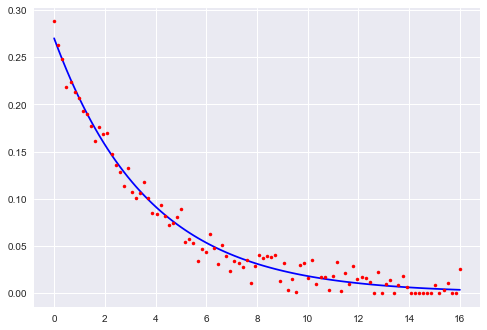

In [2]:
x = np.linspace(0,16, num = 100)
Y = [0.27*exp(-0.27*_) for _ in x]
error = norm.rvs(0, scale=0.01, size=100, random_state=3)
simulated_data = [max(0, y+e) for (y,e) in zip(Y[:100],error)]

plt.style.use('seaborn') # pretty matplotlib plots
plt.plot(x, Y, 'b-')
plt.plot(x[:100], simulated_data, 'r.')
plt.show()


Simulate a linear regression through the data

<AxesSubplot:>

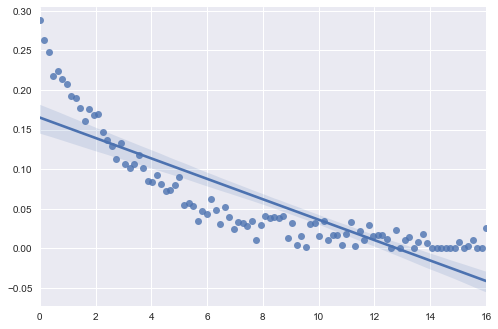

In [3]:
sns.regplot(x=x,y=simulated_data)

Place the X values and y values into a dataframe so that they can inputted into statsmodel functions later

In [4]:
X = pd.DataFrame(data = x, columns=['Value_X'])
y = pd.DataFrame(data = simulated_data, columns=['Value_y'])

Create function that generates R Diagnostic Plots

In [5]:
def R_diagnostics(X,y):

    # reference https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/
    # reference https://emredjan.medium.com/emulating-r-regression-plots-in-python-43741952c034
    # numpy std vs pandas std https://stackoverflow.com/questions/44220290/sklearn-standardscaler-result-different-to-manual-result
    # how to use OLSInfluence and its attributes https://medium.com/codex/outlier-study-and-linear-regression-diagnosis-using-python-d148223859c0

    # generate OLS model
    model = sm.OLS(y, sm.add_constant(X))
    model_fit = model.fit()

    # create dataframe from X, y for easier plot handling
    dataframe = pd.concat([X, y], axis=1)

    # model values
    model_fitted_y = model_fit.fittedvalues

    # model residuals
    model_residuals = model_fit.resid

    # normalized residuals
    # pandas std assumes ddof = 1 ==> n-1 to calculate std (sample standard deviation)
    res_mean = model_residuals.mean()
    res_std = model_residuals.std()
    model_norm_residuals = (model_residuals - res_mean)/res_std
    model_norm_residuals_sorted = model_norm_residuals.sort_values(ascending=True).reset_index()[0]

    # calculate theoretical quantiles reference https://www.statology.org/q-q-plot-excel/
    theoretical_quans = pd.DataFrame(columns=['Percentile','Theoretical_Quantiles'],index=model_residuals.index)

    # reference get num rows https://stackoverflow.com/questions/15943769/how-do-i-get-the-row-count-of-a-pandas-dataframe
    num_datapts = len(theoretical_quans.index)

    for i in theoretical_quans.index:
        theoretical_quans['Percentile'][i] = (i+1-0.5)/num_datapts

    theoretical_quans['Theoretical_Quantiles'] = theoretical_quans['Percentile'].apply(lambda x: norm.ppf(x))

    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    
    # leverage, from statsmodels internals
    # alternative code: mod_leverage = olsi(model_fit).hat_matrix_diag
    model_leverage = model_fit.get_influence().hat_matrix_diag
    
    # cook's distance, from statsmodels internals
    # alternative code: cook_dist = olsi(model_fit).cooks_distance[0]
    model_cooks = model_fit.get_influence().cooks_distance[0]

    # plot the 4 diagnostic plots
    fig, ax = plt.subplots(3,2)
    plt.style.use('seaborn') # pretty matplotlib plots
    plt.rc('font', size=12)
    plt.rc('figure', titlesize=16)
    plt.rc('axes', labelsize=13)
    plt.rc('axes', titlesize=16)
    fig.set_size_inches(14,15)

    # Residuals vs Fitted Values
    g1 = sns.regplot(x=model_fitted_y, y=model_residuals,
                              lowess=True,
                              scatter_kws={'alpha': 0.5},
                              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax[0,0])

    g1.set_title('Residuals vs Fitted')
    g1.set_xlabel('Fitted values')
    g1.set_ylabel('Residuals')

    # QQ plot
    g2 = sns.scatterplot(x=theoretical_quans['Theoretical_Quantiles'],y=model_norm_residuals_sorted, ax=ax[0,1])
    g2.set_title('Normal Q-Q')
    g2.set_xlabel('Theoretical Quantile')
    g2.set_ylabel('Standardized Residuals')
    g2.plot([3, -3], [3, -3], linewidth=1, color='r')


    # Scale-Location Plot
    g3 = sns.regplot(x=model_fitted_y, y=model_norm_residuals_abs_sqrt,
                              lowess=True,
                              scatter_kws={'alpha': 0.5},
                              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax[1,0])

    g3.set_title('Scale-Location')
    g3.set_xlabel('Fitted values')
    g3.set_ylabel('$\sqrt{|Standardized Residuals|}$')


    # Residual-Leverage Plot
    g4 = sns.regplot(x=model_leverage, y=model_norm_residuals,
                              lowess=True,
                              scatter_kws={'alpha': 0.5},
                              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax[1,1])

    g4.set_title('Residuals vs Leverage')
    g4.set_xlabel('Leverage')
    g4.set_ylabel('Standardized Residuals')

    # generate cook's distance lines in Residual-Leverage Plot reference https://emredjan.medium.com/emulating-r-regression-plots-in-python-43741952c034

    p = len(model_fit.params) # number of model parameters
    x = np.linspace(0.001, max(model_leverage), 50)
    formulapt5 = lambda x: np.sqrt((0.5 * p * (1 - x)) / x)
    formula1 = lambda x: np.sqrt((1 * p * (1 - x)) / x)
    ypt5 = [formulapt5(val) for val in x]
    ypt5n = [-formulapt5(val) for val in x]
    y1 = [formula1(val) for val in x]
    y1n = [-formula1(val) for val in x]

    g4.plot(x, ypt5, label='Cook\'s D 0.5', lw=1, ls='--', color='red')
    g4.plot(x, ypt5n, lw=1, ls='--', color='red')
    g4.plot(x, y1, label='Cook\'s D 1', lw=1, ls='--', color='green')
    g4.plot(x, y1n, lw=1, ls='--', color='green')
    g4.legend(loc='upper right');
    
    # reference https://www.python-graph-gallery.com/181-custom-lollipop-plot
    
    ax[2, 0].stem(model_cooks, markerfmt=' ')
    ax[2, 0].set_title('Cook\'s Distance')
    ax[2, 0].set_xlabel('Obs Number')
    ax[2, 0].set_ylabel('Cook\'s D Value')
    

Create Diagnostic plots with the negative exponential curve simulated data created earlier

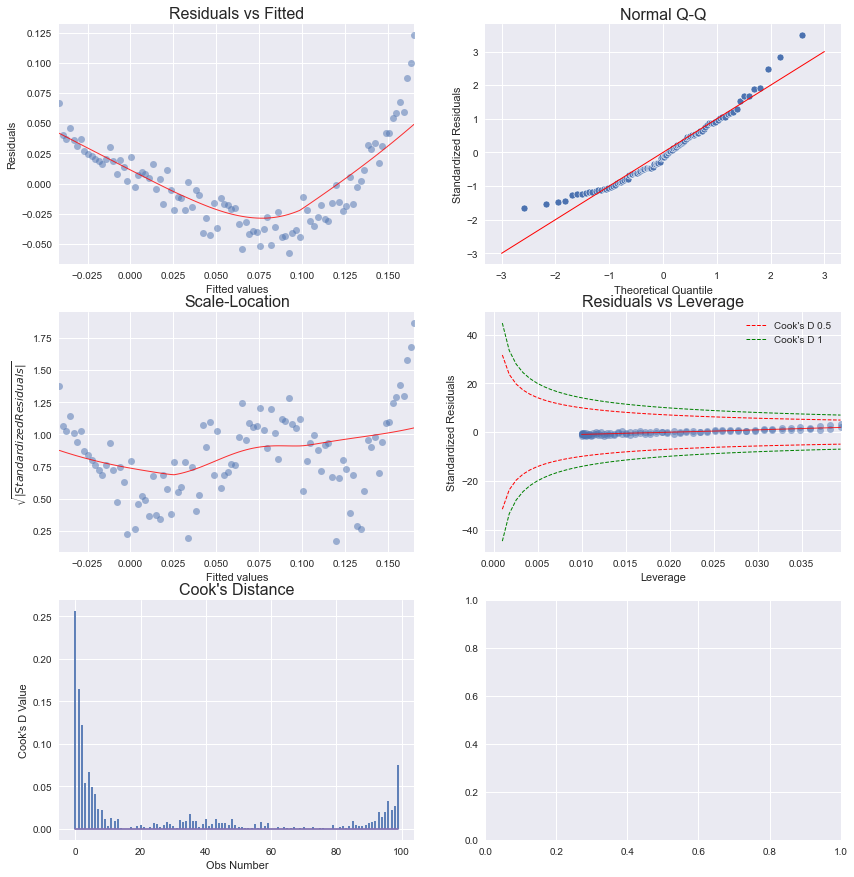

In [6]:
R_diagnostics(X,y)

Create More Simple Linear Relationship data

In [7]:
# recreate x values
x_val = np.linspace(0,16, num = 100)
# create linear relationship 
Y3 = [0.75*val for val in x]
# create random error
error3 = norm.rvs(0, scale=2, size=100, random_state =4)


Create heteroskedastic based on simple linear relationship data

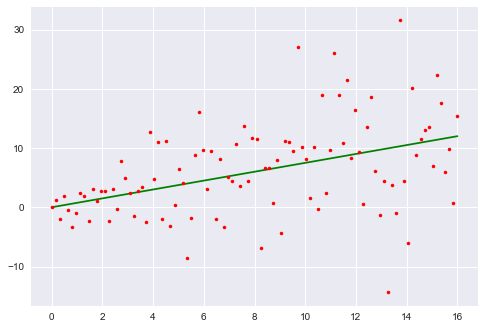

In [8]:
# create empty dataframe
df_cal = pd.DataFrame(columns=['Mult_Factor'], index=[*range(0,100)])

# create a factor that will be multiplied to the error term for Y3 variable, 
# the values will keep increasing by 0.05 for each success Y3 datapoint so that data will be heteroskedastic

for i in df_cal.index:
    if i == 0:
        df_cal['Mult_Factor'][i] = 1
    else:
        df_cal['Mult_Factor'][i] = df_cal['Mult_Factor'][i-1] + 0.05
        
# create dataframes for Y3 variable and the error values
        
df_Error3 = pd.DataFrame(data=error3, columns=['Error3'])
df_Y3 = pd.DataFrame(data=Y3, columns=['Y3'])
df_x_val = pd.DataFrame(data=x_val, columns=['x_val'])

# combine all the dataframes so that we can use them for calculations
df_comb = pd.concat([df_Error3,df_Y3,df_cal,df_x_val], axis=1, join='inner')

# create a function to create the simulated data for Y3
def Cal_Sim_Data(Error,Y,Mult_Factor):
    Sim_Val = Y + Error*Mult_Factor
    return Sim_Val

# apply the function on the data to generate the simulated data
df_comb['simulated_data3'] = df_comb[['Error3','Y3','Mult_Factor']].apply(lambda x : Cal_Sim_Data(*x), axis=1)

plt.plot(x_val, Y3, 'g-')
plt.plot(df_comb['x_val'], df_comb['simulated_data3'], 'r.')

test for heteroskedasticity using Breusch-Pagan test.

In [9]:
# reference https://www.statsmodels.org/devel/examples/notebooks/generated/regression_diagnostics.html#Heteroskedasticity-tests
# reference https://medium.com/@remycanario17/tests-for-heteroskedasticity-in-python-208a0fdb04ab

results = smf.ols("Y3 ~ x_val", data=df_comb).fit()

name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(results.resid, results.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 35.96755125053963),
 ('p-value', 2.006309918752279e-09),
 ('f-value', 55.0474031743568),
 ('f p-value', 4.299799082331911e-11)]

**Conclusion:** P value is less than 0.05. Hence at 95% confidence level, we can conclude that the data is heteroskedastic.

test for heteroskedasticity using Goldfeld-Quandt test.

In [10]:
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(results.resid, results.model.exog)
lzip(name, test)

[('F statistic', 7.326490586222889), ('p-value', 7.869433527372225e-11)]

**Conclusion:** P value is less than 0.05. Hence at 95% confidence level, we can conclude that the data is heteroskedastic.

create diagnostic plots for the heteroskedastic data

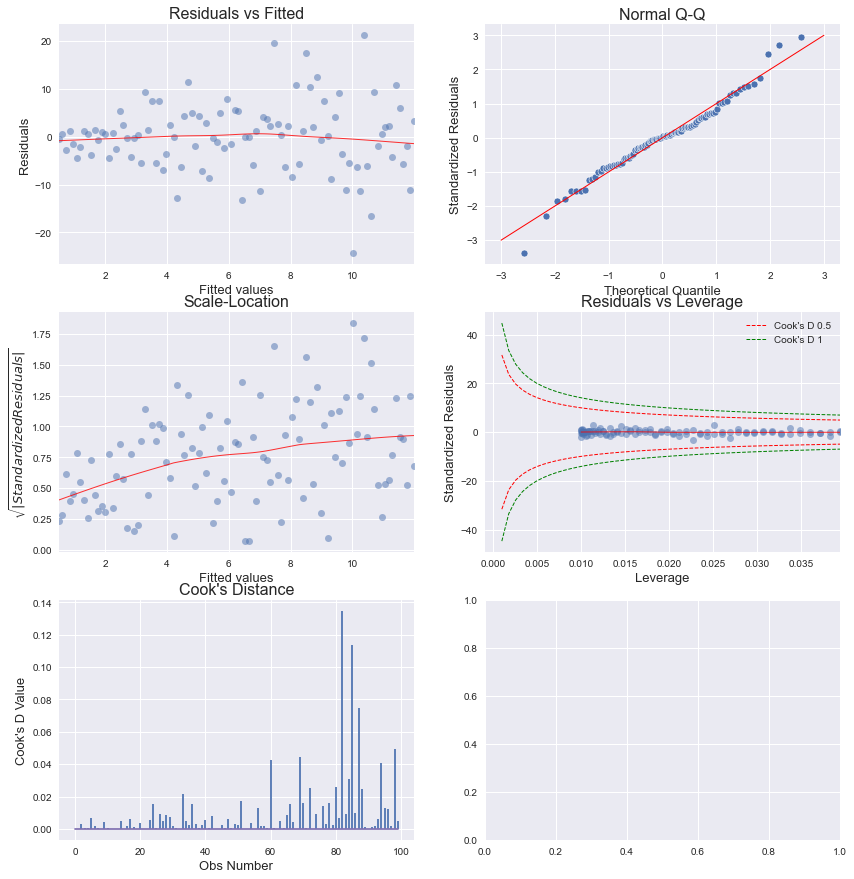

In [11]:
R_diagnostics(X,df_comb['simulated_data3'])

try to remedy heteroskedastic data with log transformation with the minimum value from the datapoints as the constant

In [12]:
min_sim3 = np.abs(df_comb['simulated_data3'].min())

df_comb['simulated_data3_log'] = df_comb['simulated_data3'].apply(lambda x : np.log(min_sim3 + 0.1 + x))

Data looks better after transformation but there appears to be one outlier. Cook's Distance for the outlier was greater than 0.5

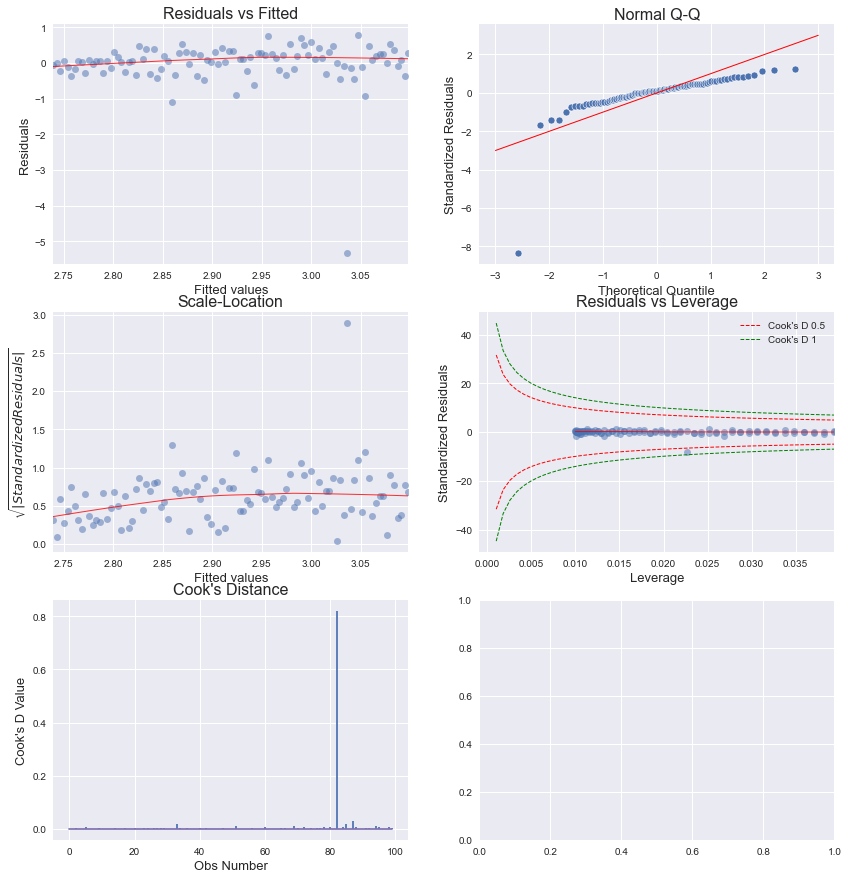

In [13]:
R_diagnostics(X,df_comb['simulated_data3_log'])

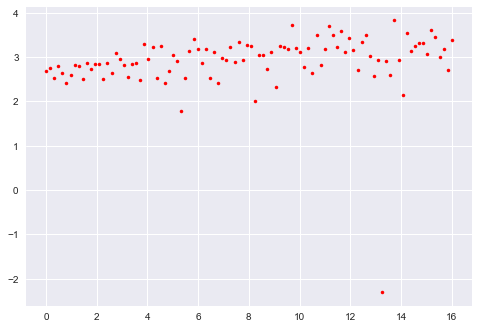

In [14]:
plt.plot(X,df_comb['simulated_data3_log'],'r.')

Decided to drop the outlier which was the minimum value of the datapoints.

In [15]:
index_min = df_comb['simulated_data3_log'].idxmin()

df_comb_no_outlier = df_comb.drop(index_min)

X_no_outlier = X.drop(index_min)

Redid the the diagnostic without the outlier and the results were better.

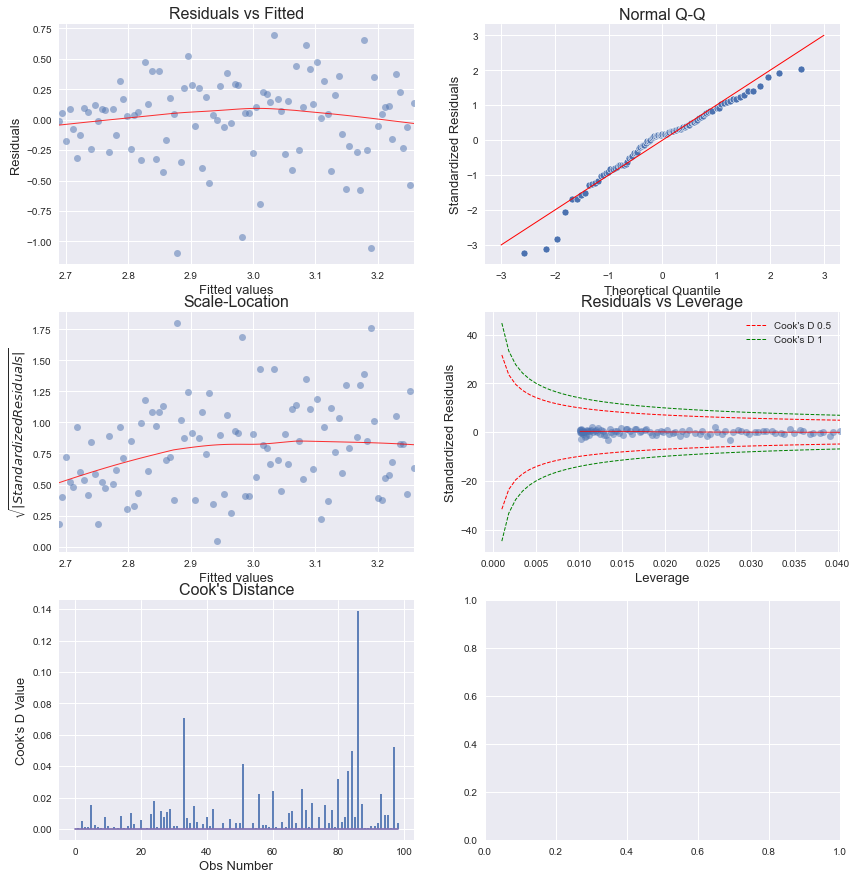

In [16]:
R_diagnostics(X_no_outlier,df_comb_no_outlier['simulated_data3_log'])